https://velog.io/@cha-suyeon/SRGAN%EC%9D%84-%EC%9D%B4%EC%9A%A9%ED%95%B4-Super-Resolution-%EA%B5%AC%ED%98%84

## 1. 데이터 불러오기

In [ ]:
import cv2
import numpy as np
import glob, os
import natsort
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator


np.random.seed(77)

In [ ]:
train_image = glob.glob('/content/drive/MyDrive/GAN/Super_resolution/train/*/*.png')
val_image = glob.glob('/content/drive/MyDrive/GAN/Super_resolution/val/*/*.png')

train_image = natsort.natsorted(train_image)
val_image = natsort.natsorted(val_image)

In [ ]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = '/content/drive/MyDrive/GAN/Super_resolution/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0

        high_img.append(img_to_array(img))


low_img = []
path = '/content/drive/MyDrive/GAN/Super_resolution/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0

        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:05<00:00, 159.47it/s]


In [ ]:
from tensorflow.keras import losses, metrics, optimizers
from sklearn.model_selection import train_test_split

# high_img, low_img
x_train, x_test, y_train, y_test = train_test_split(low_img, high_img)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_train.shape

(641, 256, 256, 3)

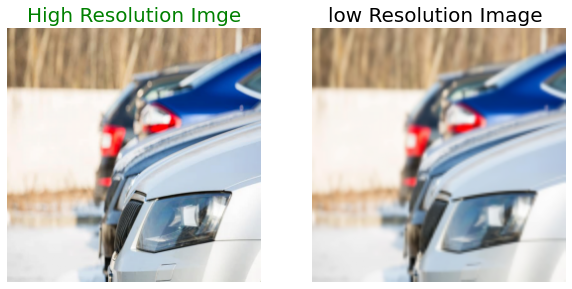

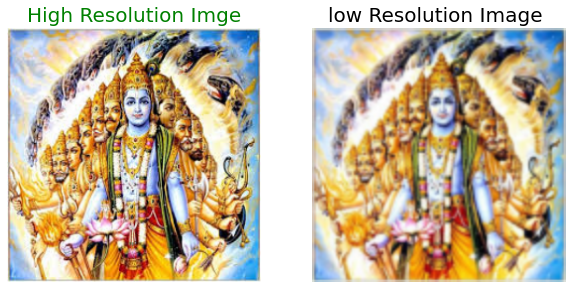

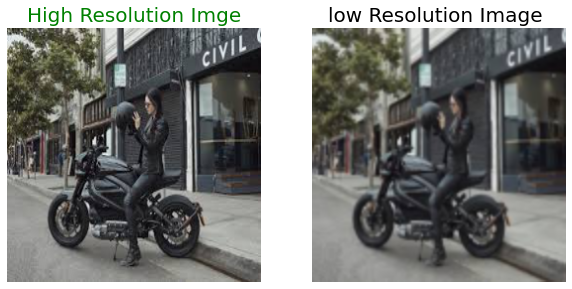

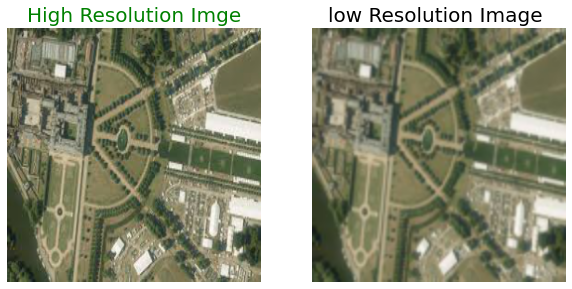

In [ ]:
for i in range(4):
    a = np.random.randint(0,600)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(y_train[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(x_train[a][:, :, ::-1])
    plt.axis('off')

## 2. Generator

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
from tensorflow.keras import Input, Model, layers

# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x,out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffer라고 쓰여진 부분을 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x,2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)

# 전체 Generator을 정의합니다.
def get_generator(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = layers.PReLU(shared_axes=[1,2])(out)

    for _ in range(5):
        out = gene_base_block(out)

    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([out, out])

    for _ in range(2):
        out = upsample_block(out)
    
    out = layers.Conv2D(3, 9, 1, "same", activation='tanh')(out)
    return Model(inputs, out)

## 3. Discriminator

In [ ]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(256, 256, 3), n_filters = 128):
    inputs = Input(input_shape)

    out = layers.Conv2D(n_filters, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)

    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)

    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

In [ ]:
vgg = tf.keras.applications.vgg19.VGG19(
        include_top = False,
        weights = "imagenet",
        input_shape=(256, 256, 3)
    )

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.python.keras import applications

def get_feature_extractor():

    # 아래 vgg.layers[20]은 vgg 내의 마지막 conv layer입니다.
    return Model(vgg.input, vgg.layers[20].output)

In [ ]:
vgg.layers[20]

## 4. Train

In [ ]:
generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()

def get_gene_loss(fake_out):
    return bce(tf.ones_lie(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)

@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)

    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75

    return mse(hr_real_feature, hr_fake_feature)

@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)

        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)

        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    gene_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss

gene_losses = metrics.Mean()
disc_losses = metrics.Mean()


for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(x_train):
        g_loss, d_loss = step(lr, hr)

        gene_losses.update_state(g_loss)
        disc_losses.update_state(d_loss)

        # 10회 반복마다 loss 출력하기
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")

        if (i+1) == 200:
            break
    
    gene_losses.reset_states()
    disc_losses.reset_states()

ValueError: ignored

In [ ]:
def training(epochs=1, batch_size=30):

    batch_count = x_train.shape[0] / batch_size
    
    # Creating GAN
    generator = get_generator()
    discriminator = get_discriminator()
    vgg = get_feature_extractor()
    gan = create_gan(discriminator, generator)
    
    ## structure of model
    from keras.utils import plot_model
    plot_model(generator, show_shapes=True, to_file='generator.png')
    
    plot_model(discriminator, show_shapes=True, to_file='discriminator.png')
    
    plot_model(gan, show_shapes=True, to_file='gan.png')
    
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        # Generate random noise as an input to initialize the generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]
            
            # Construct different batches of real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            # Pretrain discriminator on  fake and real data before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            # Tricking the noised input of the Generator as real data
            y_gen = np.ones(batch_size)
            
            # During the training of gan, the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            # Training  the GAN by alternating the training of the Discriminator and training the chained GAN model with Discriminator's weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           plot_generated_images(e, generator)

training(400,128)

## 5. 평가

In [ ]:
import numpy as np

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, o, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.unit8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4",
    split=["train", "validation"],
    as_supervised=True
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr)

In [ ]:
# 자세히 시각화하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개의 값입니다.

left_tops = [(400,500), (300,1200), (0,1000)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr, left_top, 200, 200)
    img3 = crop(hr, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)